In [2]:
# !pip install ultralytics
# !pip install PyMCubes
# !pip install trimesh
# !git clone https://github.com/facebookresearch/ss3d.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.3/274.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.9/688.9 kB 4.2 MB/s eta 0:00:00
Cloning into 'ss3d'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 88 (delta 36), reused 58 (delta 14), pack-reused 0
Receiving objects: 100% (88/88), 2.07 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
from ultralytics import YOLO
import cv2
import torch
def seg(input_image_path,output_image_path):
  model = YOLO('yolov8m-seg.pt')
  results = model(input_image_path)
  for result in results:
      masks = result.masks.data
      people_mask = torch.any(masks, dim=0).int() * 255
      cv2.imwrite((output_image_path), people_mask.cpu().numpy())
      break

In [12]:
input_image_path = "/content/drive/MyDrive/hybrid_yolov8_ss3d/akash.jpg"
output_image_path = "/content/drive/MyDrive/hybrid_yolov8_ss3d/output.png"
seg(input_image_path, output_image_path)


image 1/1 /content/drive/MyDrive/hybrid_yolov8_ss3d/akash.jpg: 640x640 1 person, 46.2ms
Speed: 4.0ms preprocess, 46.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


In [13]:
import torch
from ss3d.data_utils import generate_input_img, extract_trimesh
from ss3d.model import VNet
from IPython.display import Image
from torchvision.transforms import ToPILImage
from matplotlib.pyplot import imshow

In [6]:
# !wget https://dl.fbaipublicfiles.com/ss3d/distilled_model.torch

--2024-01-01 17:29:31--  https://dl.fbaipublicfiles.com/ss3d/distilled_model.torch
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144319227 (138M) [binary/octet-stream]
Saving to: ‘distilled_model.torch’

distilled_model.tor 100%[===================>] 137.63M  60.2MB/s    in 2.3s    

2024-01-01 17:29:33 (60.2 MB/s) - ‘distilled_model.torch’ saved [144319227/144319227]



In [14]:
model_3d = VNet()
model_3d.load_state_dict(torch.load("/content/distilled_model.torch"))
model_3d.eval()

VNet(
  (decoder): SirenFiLM(
    (net): ModuleList(
      (0): SineFiLMLayer(
        (linear): Linear(in_features=3, out_features=256, bias=True)
      )
      (1-5): 5 x SineFiLMLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (6): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (encoder): Resnet34ResFC(
    (features): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv

In [15]:
from PIL import Image
import os

def resize_image(input_path, output_path, new_size):
    try:
        with Image.open(input_path) as img:
            resized_img = img.resize(new_size)
            resized_img.save(output_path)
            print(f"Image resized and saved to {output_path}")
    except Exception as e:
        print(f"Error: {e}")
new_size = (512, 512)
resize_image(input_image_path, input_image_path, new_size)
resize_image(output_image_path, output_image_path, new_size)

Image resized and saved to /content/drive/MyDrive/hybrid_yolov8_ss3d/akash.jpg
Image resized and saved to /content/drive/MyDrive/hybrid_yolov8_ss3d/output.png


In [17]:
rgb_img_path = input_image_path
mask_img_path = output_image_path
inp_img = generate_input_img(
    rgb_img_path,
    mask_img_path,
)

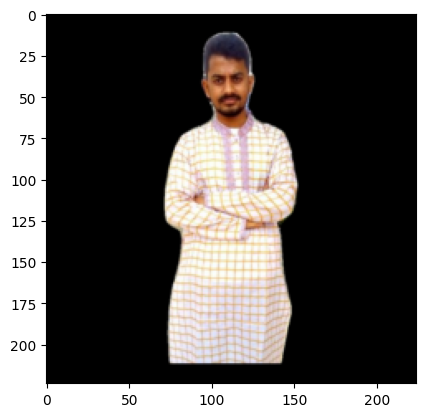

In [18]:
imshow(inp_img.squeeze(0).permute(1,2,0).cpu().numpy())

In [19]:
%%capture --no-display
out_mesh = extract_trimesh(model_3d, inp_img, "cuda")
out_mesh.show()